<a href="https://colab.research.google.com/github/mrdbourke/pytorch-deep-learning/blob/main/07_pytorch_experiment_tracking_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# (WIP) 07. PyTorch Experiment Tracking V2

> **Note:** This notebook is a cloned version of [`07_pytorch_experiment_tracking.ipynb`](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/07_pytorch_experiment_tracking.ipynb) but adapted to work with `torchvision`'s upcoming [multi-weight support API (coming in `torchvision` v0.13)](https://pytorch.org/blog/introducing-torchvision-new-multi-weight-support-api/). 
>
> As of June 2022, it requires the [nightly versions of PyTorch and `torchvision` be installed](https://pytorch.org/get-started/locally/).
>
> Once `torchvision` v0.13 becomes the standard (not nightly), this notebook (V2) will replace the previous version.

We've trained a fair few models now on the journey to making FoodVision Mini (an image classification model to classify images of pizza, steak or sushi).

And so far we've keep track of them via Python dictionaries.

Or just comparing them by the metric print outs during training.

What if you wanted to run a dozen (or more) different models at once?

Surely there's a better way...

There is.

**Experiment tracking.**

This notebook answers the question: **how do I track my machine learning experiments?**

## TK - What is experiment tracking?

Machine learning and deep learning are very experimental.

You have to put your artist's beret/chef's hat on to cook up lots of different models.

And you have to put on your scientist's coat to track the results of various combinations of data, model architectures and training regimes.

That's where **experiment tracking** comes in.

If you're running lots of different experiments, **experiment tracking helps you figure out what works and what doesn't**.

TK image - tracking different experiments in different files and things getting out of hand...

## TK - Why track experiments?

If you're only running a handful of models (like we've done so far), it might be okay just to track their results in print outs and a few dictionaries.

However, as the number of experiments you run starts to increase, this naive way of tracking could get out of hand.

So if you're following the machine learning practitioner's motto of *experiment, experiment, experiment!*, you'll want a way to track them.

## TK - Different ways to track machine learning experiments 

There are as many different ways to track machine learning experiments as there is experiments to run.

This table covers a few.

| **Method** | **Setup** | **Pros** | **Cons** | **Cost** |
| ----- | ----- | ----- | ----- | ----- |
| Python dictionaries, CSV files, print outs | None | Easy to setup, runs in pure Python | Hard to keep track of large numbers of experiments | Free |
| [TensorBoard](https://www.tensorflow.org/tensorboard/get_started) | Minimal, install [`tensorboard`](https://pypi.org/project/tensorboard/) | Extensions built into PyTorch, widely recognized and used, easily scales. | User-experience not as nice as other options. | Free |
| [Weights & Biases Experiment Tracking](https://wandb.ai/site/experiment-tracking) | Minimal, install [`wandb`](https://docs.wandb.ai/quickstart), make an account. | Incredible user experience, make experiments public, tracks almost anything | Requires external resource outside of PyTorch. | Free for personal use | 
| [MLFlow](https://mlflow.org/) | Minimal, install `mlflow` and starting tracking | Fully open-source MLOps lifecycle management, many integrations. | Little bit harder to setup a remote tracking server than other services. | Free | 

> **Note:** There are other managed options similar to Weights & Biases and open-source options similar to MLFlow but I've left them out for brevity. You can find more by searching "machine learning experiment tracking".

## TK - What we're going to cover

Due to its tight integration with PyTorch and widespread use, this notebook focuses on TensorBoard.

However, the principles we're going to cover are similar across all of the other methods of tracking experiments.


TODO

UPTOHERE...

TK - table of contents...



## TK - Where can you get help?

All of the materials for this course [are available on GitHub](https://github.com/mrdbourke/pytorch-deep-learning).

If you run into trouble, you can ask a question on the course [GitHub Discussions page](https://github.com/mrdbourke/pytorch-deep-learning/discussions).

And of course, there's the [PyTorch documentation](https://pytorch.org/docs/stable/index.html) and [PyTorch developer forums](https://discuss.pytorch.org/), a very helpful place for all things PyTorch. 

## TK 0. Getting setup 

Let's start by download all of the modules we'll need for this section.

To save us writing extra code, we're going to be leveraging some of the Python scripts (such as `data_setup.py` and `engine.py`) we created in the previous section, [05. PyTorch Going Modular](https://www.learnpytorch.io/05_pytorch_going_modular/).

Specifically, we're going to download the [`going_modular`](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/going_modular) directory from the `pytorch-deep-learning` repository (if we don't already have it).

We'll also get the [`torchinfo`](https://github.com/TylerYep/torchinfo) package if it's not available. 

`torchinfo` will help later on to give us a visual representation of our model.

In [4]:
# # Nightly versions of torch and torchvision required
# !pip3 install -U --pre torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/nightly/cu113

In [5]:
# Check versions of torch and torchvision
import torch
import torchvision 

print(f"torch version: {torch.__version__} (should be 0.12+)") 
print(f"torchvision version: {torchvision.__version__} (should be 0.13+)")

torch version: 1.13.0.dev20220606 (should be 0.12+)
torchvision version: 0.14.0.dev20220606 (should be 0.13+)


In [6]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

Now let's setup device agnostic code.

> **Note:** If you're using Google Colab, and you don't have a GPU turned on yet, it's now time to turn one on via `Runtime -> Change runtime type -> Hardware accelerator -> GPU`.

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### TK Create a helper function to set seeds

Since we've been setting random seeds a whole bunch throughout previous sections, how about we functionize it?

Let's create a function to "set the seeds" called `set_seeds()`.

> **Note:** Recall a [random seed](https://en.wikipedia.org/wiki/Random_seed) is a way of flavouring the randomness generated by a computer. They aren't necessary to always set when running machine learning code, however, they help ensure there's an element of reproducibility (the numbers I get with my code are similar to the numbers you get with your code). Outside of an education or experimental setting, random seeds generally aren't required.

In [8]:
# Set seeds
def set_seeds(seed: int=42):
    """Sets random sets for torch operations.

    Args:
        seed (int, optional): Random seed to set. Defaults to 42.
    """
    # Set the seed for general torch operations
    torch.manual_seed(seed)
    # Set the seed for CUDA torch operations (ones that happen on the GPU)
    torch.cuda.manual_seed(seed)

## TK 1. Get data

As always, before we can run machine learning experiments, we'll need a dataset.

We're going to continue trying to improve upon the results we've been getting on FoodVision Mini.

In the previous section, [06. PyTorch Transfer Learning](https://www.learnpytorch.io/06_pytorch_transfer_learning/), we saw how powerful using a pretrained model could be when classifying images of pizza, steak and sushi.

So how about we try and improve our results?

To do so, we'll use similar code to the previous section to download the [`pizza_steak_sushi.zip`](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi.zip) (if the data doesn't already exist) except this time its been functionised.

This will allow us to use it again later. 

In [9]:
import os
import zipfile

from pathlib import Path

import requests

def download_data(source: str, 
                  destination: str,
                  remove_source: bool = True) -> Path:
    """Downloads a zipped dataset from source and unzips to destination.

    Args:
        source (str): A link to a zipped file containing data.
        destination (str): A target directory to unzip data to.
        remove_source (bool): Whether to remove the source after downloading and extracting.
    
    Returns:
        pathlib.Path to downloaded data.
    
    Example usage:
        download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                      destination="pizza_steak_sushi")
    """
    # Setup path to data folder
    data_path = Path("data/")
    image_path = data_path / destination

    # If the image folder doesn't exist, download it and prepare it... 
    if image_path.is_dir():
        print(f"[INFO] {image_path} directory exists, skipping download.")
    else:
        print(f"[INFO] Did not find {image_path} directory, creating one...")
        image_path.mkdir(parents=True, exist_ok=True)
        
        # Download pizza, steak, sushi data
        target_file = Path(source).name
        with open(data_path / target_file, "wb") as f:
            request = requests.get(source)
            print(f"[INFO] Downloading {target_file} from {source}...")
            f.write(request.content)

        # Unzip pizza, steak, sushi data
        with zipfile.ZipFile(data_path / target_file, "r") as zip_ref:
            print(f"[INFO] Unzipping {target_file} data...") 
            zip_ref.extractall(image_path)

        # Remove .zip file
        if remove_source:
            os.remove(data_path / target_file)
    
    return image_path

image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

Excellent! Looks like we've got our pizza, steak and sushi images in standard image classification format ready to go.

## TK 2. Create Datasets and DataLoaders

Now we've got some data, let's turn it into PyTorch DataLoaders.

We can do so using the `create_dataloaders()` function we created in [05. PyTorch Going Modular part 2](https://www.learnpytorch.io/05_pytorch_going_modular/#2-create-datasets-and-dataloaders-data_setuppy).

And since we'll be using transfer learning and specifically pretrained models from [`torchvision.models`](https://pytorch.org/vision/stable/models.html), we'll create a transform to prepare our images correctly.

To transform our images in tensors, we can use:
1. Manually created transforms using `torchvision.transforms`.
2. Automatically created transforms using `torchvision.models.MODEL_NAME.MODEL_WEIGHTS.DEFAULT.transforms()`.
    * Where `MODEL_NAME` is a specific `torchvision.models` architecture, `MODEL_WEIGHTS` is a specific set of pretrained weights and `DEFAULT` means the "best available weights".
    
We saw an example of each of these in [06. PyTorch Transfer Learning section 2](https://www.learnpytorch.io/06_pytorch_transfer_learning/#2-create-datasets-and-dataloaders).

Let's see first an example of manually created a `torchvision.transforms` pipeline (creating this way gives the most customization but can potentially result in performance degradation if the transforms don't match the pretrained model).

The main manual transformation we need to be sure of is that all of our images are normalized in ImageNet format (this is because pretrained `torchvision.models` are all pretrained on ImageNet).

We can do this with:

```python
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
```

In [10]:
# Setup dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

# Setup ImageNet normalization levels (turns all images into similar distribution as ImageNet)
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize
])           
print(f"Manually created transforms: {manual_transforms}")

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=32
)

train_dataloader, test_dataloader, class_names

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


(<torch.utils.data.dataloader.DataLoader at 0x7f95de721de0>,
 ['pizza', 'steak', 'sushi'])

Data transformed and DataLoaders created!

Let's now see what the same transformation pipeline looks like but this time by using automatic transforms.

We can do this by first instantiating a set of pretrained weights (for example `weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT`)  we'd like to use and calling the `transforms()` method on it.

In [78]:
# Setup dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

# Setup pretrained weights (plenty of these available in torchvision.models)
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT

# Get transforms from weights (these are the transforms that were used to obtain the weights)
automatic_transforms = weights.transforms() 
print(f"Automatically created transforms: {automatic_transforms}")

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=automatic_transforms, # use automatic created transforms
    batch_size=32
)

train_dataloader, test_dataloader, class_names

Automatically created transforms: ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)


(<torch.utils.data.dataloader.DataLoader at 0x7f94e34c4d30>,
 ['pizza', 'steak', 'sushi'])

## TK 3. Getting a pretrained model, freezing the base layers and changing the classifier head

Before we run multiple modelling experiments, let's see what it's like to track one.

And since our data is ready, the next thing we'll need is a model.

Let's download the pretrained weights for a `torchvision.models.efficientnet_b0()` model and prepare it for use with our own data.

In [79]:
# Note: This is how a pretrained model would be created in torchvision > 0.13, it will be deprecated in future versions.
# model = torchvision.models.efficientnet_b0(pretrained=True).to(device) # OLD 

# Download the pretrained weights for EfficientNet_B0
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # NEW in torchvision 0.13, "DEFAULT" means "best weights available"

# Setup the model with the pretrained weights and send it to the target device
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

# View the output of the model
# model

Wonderful!

Now we've got a pretrained model let's turn into a feature extractor model.

In essence, we'll freeze the base layers of the model (use these feature extracting) and we'll change the classifier head (output layer) to suit the number of classes we're working with (we've got 3 classes: pizza, steak, sushi).

> **Note:** The idea of creating a feature extractor model (what we're doing here) was covered in more depth in [06. PyTorch Transfer Learning section 3.2: Setting up a pretrained model](https://www.learnpytorch.io/06_pytorch_transfer_learning/#32-setting-up-a-pretrained-model).

In [80]:
# Freeze all base layers by setting requires_grad attribute to False
for param in model.features.parameters():
    param.requires_grad = False

In [81]:
# Since we're creating a new layer with random weights (torch.nn.Linear), 
# let's set the seeds
set_seeds() 

# Update the classifier head to suit our problem
model.classifier = torch.nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, 
              out_features=len(class_names),
              bias=True).to(device))

In [82]:
summary(model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

## TK 4. Train model and track results

Model ready to go!

Let's get ready to train it by creating a loss function and an optimizer.

Since we're working with multiple classes, we'll use [`torch.nn.CrossEntropyLoss()`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) as the loss function.

And we'll stick with [`torch.optim.Adam()`](https://pytorch.org/docs/stable/optim.html) with learning rate of `0.001` for the optimizer. 

In [83]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### TK Adjust `train()` function to track results with `SummaryWriter()`

Beautiful!

All of the pieces of our training code are starting to come together.

Let's now add the final piece to track our experiments.

Previously we've tracked our modelling experiments using multiple Python dictionaries (one for each model).

But you can imagine this could get out of hand if we were running anything more than a few experiments.

Not to worry, there's a better option!

We can use PyTorch's [`torch.utils.tensorboard.SummaryWriter()`](https://pytorch.org/docs/stable/tensorboard.html) class to save various parts of our model's training progress to file.

By default, the `SummaryWriter()` class saves various information about our model to a file set by the `log_dir` parameter.

The default location for `log_dir` is under `runs/CURRENT_DATETIME_HOSTNAME`, where the `HOSTNAME` is the name of your computer.

But of course, you can change where your experiments are tracked (the filename is as customisable as you'd like).

The outputs of the `SummaryWriter()` are saved in [TensorBoard format](https://www.tensorflow.org/tensorboard/).

TensorBoard is a part of the TensorFlow deep learning library and is an excellent way to visualize different parts of your model.

Let's create a default `SummaryWriter()` instance.



In [84]:
from torch.utils.tensorboard import SummaryWriter

# Create a writer with all default settings
writer = SummaryWriter()

Now to use the writer, we could write a new training loop or we could adjust the existing `train()` function we created in [05. PyTorch Going Modular](https://www.learnpytorch.io/05_pytorch_going_modular/#4-creating-train_step-and-test_step-functions-and-train-to-combine-them).

Let's take the latter option.

We'll get the `train()` function from `engine.py` and adjust it to use `writer`.

Specifically, we'll add the ability for our `train()` function to log our model's training and test loss and accuracy values.

We can do this with [`writer.add_scalars(main_tag, tag_scalar_dict)`](https://pytorch.org/docs/stable/tensorboard.html#torch.utils.tensorboard.writer.SummaryWriter.add_scalars), where:
* `main_tag` (string) - the name for the scalars being tracked (e.g. "Accuracy")
* `tag_scalar_dict` (dict) - a dictionary of the values being tracked (e.g. `{"train_loss": 0.3454}`)
    * > **Note:** The method is called `add_scalars()` because our loss and accuracy values are generally scalars (single values).

Once we've finished tracking values, we'll call `writer.close()` to tell the `writer` to stop looking for values to track.

To modify `train()` we'll import `train_step()` and `test_step()` from [`engine.py`](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/going_modular/going_modular/engine.py).

> **Note:** You can track information about your model almost anywhere in your code. But quite often experiments will be tracked *while* a model is training (inside a training/testing loop).
>
> The `torch.utils.tensorboard.SummaryWriter()` class also has many different methods to track different things about your model/data, such as [`add_graph()`](https://pytorch.org/docs/stable/tensorboard.html#torch.utils.tensorboard.writer.SummaryWriter.add_graph) which tracks the computation graph of your model. For more options, [check the `SummaryWriter()` documentation](https://pytorch.org/docs/stable/tensorboard.html#torch.utils.tensorboard.writer.SummaryWriter).

In [85]:
from typing import Dict, List
from tqdm.auto import tqdm

from going_modular.going_modular.engine import train_step, test_step

# Import train() function from: 
# https://github.com/mrdbourke/pytorch-deep-learning/blob/main/going_modular/going_modular/engine.py
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
      model: A PyTorch model to be trained and tested.
      train_dataloader: A DataLoader instance for the model to be trained on.
      test_dataloader: A DataLoader instance for the model to be tested on.
      optimizer: A PyTorch optimizer to help minimize the loss function.
      loss_fn: A PyTorch loss function to calculate loss on both datasets.
      epochs: An integer indicating how many epochs to train for.
      device: A target device to compute on (e.g. "cuda" or "cpu").
      
    Returns:
      A dictionary of training and testing loss as well as training and
      testing accuracy metrics. Each metric has a value in a list for 
      each epoch.
      In the form: {train_loss: [...],
                train_acc: [...],
                test_loss: [...],
                test_acc: [...]} 
      For example if training for epochs=2: 
              {train_loss: [2.0616, 1.0537],
                train_acc: [0.3945, 0.3945],
                test_loss: [1.2641, 1.5706],
                test_acc: [0.3400, 0.2973]} 
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           device=device)
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn,
                                        device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        ### New ###
        # Add loss results to SummaryWriter
        writer.add_scalars(main_tag="Loss", 
                           tag_scalar_dict={"train_loss": train_loss,
                                            "test_loss": test_loss},
                           global_step=epoch)

        # Add accuracy results to SummaryWriter
        writer.add_scalars(main_tag="Accuracy", 
                           tag_scalar_dict={"train_acc": train_acc,
                                            "test_acc": test_acc}, 
                           global_step=epoch)
        
        # Track the PyTorch model architecture
        writer.add_graph(model=model, 
                         # Pass in an example input
                         input_to_model=torch.randn(32, 3, 224, 224).to(device))
    
    # Close the writer
    writer.close()

    # Return the filled results at the end of the epochs
    return results

Woohoo!

Our `train()` function is now updated to use a `SummaryWriter()` instance to track our model's results.

How about we try it out for 5 epochs?

In [87]:
# Train model
# Note: Not using engine.train() since the original script isn't updated to use writer
set_seeds()

results = train(model=model,
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=5,
                device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5299 | train_acc: 0.9297 | test_loss: 0.5659 | test_acc: 0.8759
Epoch: 2 | train_loss: 0.5773 | train_acc: 0.8047 | test_loss: 0.5413 | test_acc: 0.8759
Epoch: 3 | train_loss: 0.5618 | train_acc: 0.8086 | test_loss: 0.4923 | test_acc: 0.8759
Epoch: 4 | train_loss: 0.4671 | train_acc: 0.9336 | test_loss: 0.4987 | test_acc: 0.8769
Epoch: 5 | train_loss: 0.5054 | train_acc: 0.7930 | test_loss: 0.5367 | test_acc: 0.8769


> **Note:** You might notice the results here are slightly different to what our model got in 06. PyTorch Transfer Learning. The difference comes from using the `engine.train()` and our modified `train()` function. Can you guess why? The [PyTorch documentation on randomness](https://pytorch.org/docs/stable/notes/randomness.html) may help more.

Running the cell above we get similar outputs we got in [06. PyTorch Transfer Learning section 4: Train model](https://www.learnpytorch.io/06_pytorch_transfer_learning/#4-train-model) but the difference is behind the scenes our `writer` instance has created a `runs/` directory storing our model's results.

TK - filename of "runs/..." dir

We'll check these out in a second but just as a reminder, we were previously tracking our model's results in a dictionary.

In [12]:
# Check out the model results
results

{'train_loss': [1.09035424888134,
  0.9228200018405914,
  0.7823289185762405,
  0.6842461675405502,
  0.7166478410363197],
 'train_acc': [0.421875, 0.61328125, 0.734375, 0.84765625, 0.69921875],
 'test_loss': [0.9086348017056783,
  0.7941891352335612,
  0.6708019773165385,
  0.6610560615857443,
  0.6622093121210734],
 'test_acc': [0.5085227272727273,
  0.8049242424242425,
  0.9071969696969697,
  0.8049242424242425,
  0.7850378787878788]}

Hmmm, we could format this to be a nice plot but could you image keeping track of a bunch of these dictionaries?

There has to be a better way...

## TK 5. View our model's results in TensorBoard

The `SummaryWriter()` class stores our model's results by default in a directory called `runs/` in TensorBoard format.

TensorBoard is a visualization program created by the TensorFlow team to view and inspect information about models and data.

You know what that means?

It's time to follow the data visualizer's motto and *visualize, visualize, visualize!* 

You can view TensorBoard in a number of ways:

| Code environment | How to view TensorBoard | Resource |
| ----- | ----- | ----- |
| VS Code (notebooks or Python scripts) | Press `SHIFT + CMD + P` to open the Command Palette and search for the command "Python: Launch TensorBoard". | [VS Code Guide on TensorBoard and PyTorch](https://code.visualstudio.com/docs/datascience/pytorch-support#_tensorboard-integration) |
| Jupyter and Colab Notebooks | Make sure [TensorBoard is installed](https://pypi.org/project/tensorboard/), load it with `%load_ext tensorboard` and then view your results with `%tensorboard --logdir DIR_WITH_LOGS`. | [`torch.utils.tensorboard`](https://pytorch.org/docs/stable/tensorboard.html) and [Get started with TensorBoard](https://www.tensorflow.org/tensorboard/get_started) |

You can also upload your experiments to [tensorboard.dev](https://tensorboard.dev/) to share them publicly with others.

Running the following code in a Google Colab or Jupyter Notebook will start an interactive TensorBoard session to view TensorBoard files in the `runs/` directory.

```python
%load_ext tensorboard # line magic to load TensorBoard
%tensorboard --logdir runs # run TensorBoard session with the "runs/" directory
```

In [13]:
# Example code to run in Jupyter or Google Colab Notebook (uncomment to try it out)
# %load_ext tensorboard
# %tensorboard --logdir runs

If all went correctly, you should see something like the following:

* TK image - tensorboard session with `runs/` directory 
* TK explain the different things you can view on TensorBoard

> **Note:** For more information on running TensorBoard in notebooks or in other locations, see the following:
> * [Using TensorBoard in Notebooks guide by TensorFlow](https://www.tensorflow.org/tensorboard/tensorboard_in_notebooks)
> * [Get started with TensorBoard.dev](https://tensorboard.dev/#get-started) (helpful for uploading your TensorBoard logs to a shareable link)

## TK 6. Create a helper function to build `SummaryWriter()` instances

The `SummaryWriter()` class logs various information to a directory specified by the `log_dir` parameter.

How about we make a helper function to create a custom directory per experiment?

For example, say we'd like to track things like:
* **Experiment date/timestamp** - when did the experiment take place?
* **Experiment name** - is there something we'd like to call the experiment?
* **Model name** - what model was used?
* **Extra** - should anything else be tracked?

You could track almost anything here and be as creative as you want but these should be enough to start.

Let's create a helper function called `create_writer()` that produces a `SummaryWriter()` instance tracking to a custom `log_dir`.

Ideally, we'd like the `log_dir` to be something like: 

`runs/YYYY-MM-DD/experiment_name/model_name/extra` 

Where `YYYY-MM-DD` is the date the experiment was run (you could add the time as well).

In [96]:
def create_writer(experiment_name: str, 
                  model_name: str, 
                  extra: str=None) -> torch.utils.tensorboard.writer.SummaryWriter():
    """Creates a torch.utils.tensorboard.writer.SummaryWriter() instance saving to a specific log_dir.

    log_dir is combination of runs/timestamp_experiment_name_model_name_extra.

    Where timestamp is the current date in YYYY-MM-DD format.

    Args:
        experiment_name (str): Name of experiment.
        model_name (str): Name of model.
        extra (str, optional): Anything extra to add to the directory. Defaults to None.

    Returns:
        torch.utils.tensorboard.writer.SummaryWriter(): Instance of a writer saving to log_dir.

    Example usage:
        writer = create_writer(experiment_name="data_10_percent",
                               model_name="effnetb2",
                               extra="5_epochs")
        This is the same as:
        writer = SummaryWriter(log_dir="runs/2022-06-04/data_10_percent/effnetb2/5_epochs/")
    """
    from datetime import datetime
    import os

    # Get timestamp of current date (all experiments on certain day live in same folder)
    timestamp = datetime.now().strftime("%Y-%m-%d") # returns current date in YYYY-MM-DD format

    if extra:
        # Create log directory path
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name, extra)
    else:
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name)
        
    print(f"[INFO] Created SummaryWriter, saving to: {log_dir}...")
    return SummaryWriter(log_dir=log_dir)

Beautiful!

Now we've got a `create_writer()` function, let's try it out.

In [97]:
# Create an example writer
example_writer = create_writer(experiment_name="data_10_percent",
                               model_name="effnetb0",
                               extra="5_epochs")

[INFO] Created SummaryWriter, saving to: runs/2022-06-10/data_10_percent/effnetb0/5_epochs...


Looking good, now we've got a way to log and trace back our various experiments.

### TK 6.1 Update the `train()` function to include a `writer` parameter

Our `create_writer()` function works fantastic.

How about we give our `train()` function the ability to take in a `writer` parameter so we actively update the `SummaryWriter()` instance we're using each time we call `train()`.

For example, say we're running a series of experiments, calling `train()` multiple times for multiple different models, it would be good if each experiment used a different `writer`.

One `writer` per experiment.

To adjust the `train()` function we'll add a `writer` parameter to the function and then we'll add some code to see if there's a `writer` and if so, we'll track our information there.

In [98]:
from typing import Dict, List
from tqdm.auto import tqdm

# Add writer parameter to train()
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device, 
          writer: torch.utils.tensorboard.writer.SummaryWriter # new parameter to take in a writer
          ) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Stores metrics to specified writer log_dir if present.

    Args:
      model: A PyTorch model to be trained and tested.
      train_dataloader: A DataLoader instance for the model to be trained on.
      test_dataloader: A DataLoader instance for the model to be tested on.
      optimizer: A PyTorch optimizer to help minimize the loss function.
      loss_fn: A PyTorch loss function to calculate loss on both datasets.
      epochs: An integer indicating how many epochs to train for.
      device: A target device to compute on (e.g. "cuda" or "cpu").
      writer: A SummaryWriter() instance to log model results to.

    Returns:
      A dictionary of training and testing loss as well as training and
      testing accuracy metrics. Each metric has a value in a list for 
      each epoch.
      In the form: {train_loss: [...],
                train_acc: [...],
                test_loss: [...],
                test_acc: [...]} 
      For example if training for epochs=2: 
              {train_loss: [2.0616, 1.0537],
                train_acc: [0.3945, 0.3945],
                test_loss: [1.2641, 1.5706],
                test_acc: [0.3400, 0.2973]} 
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)


        ### New ###
        # See if there's a writer, if so, log to it
        if writer:
            # Add results to SummaryWriter
            writer.add_scalars(main_tag="Loss", 
                               tag_scalar_dict={"train_loss": train_loss,
                                                "test_loss": test_loss},
                               global_step=epoch)
            writer.add_scalars(main_tag="Accuracy", 
                               tag_scalar_dict={"train_acc": train_acc,
                                                "test_acc": test_acc}, 
                               global_step=epoch)

            # Close the writer
            writer.close()
        else:
            pass
    
    # Close the writer
    writer.close()

    # Return the filled results at the end of the epochs
    return results

## TK - 7. Setting up a series of modelling experiments

It's to step things up a notch.

Previously we've been running various experiments and inspecting the results one by one.

But what if we could run multiple experiments and then inspect the results all together?

Well, that's what we're going to set up.

### 7.2 What kind of experiments should you run?

That's the million dollar question in machine learning.

Because there's really no limit to the experiments you can run.

Such a freedom is why machine learning is so exciting and terrifying at the same time.

This where you'll have to put on your scientist hat and remember the machine learning practitioner's motto: *experiment, experiment, experiment!*

Every hyperparameter stands as a starting point for a different experiment: 
* Change the number of epochs.
* Change the number of layers/hidden units.
* Change the amount of data.
* Change the learning rate.
* Try different kinds of data augmentation.
* Train for a different number of epochs.
* Choose a different model architecture. 

With practice and running many different experiments, you'll start to build an intuition of what *might* help your model.

I say *might* on purpose because there's no guarantees.

But generally, in light of [*The Bitter Lesson*](http://www.incompleteideas.net/IncIdeas/BitterLesson.html) (I've mentioned this twice now because it's an important essay in the world of AI), the bigger your model (more learnable parameters) and the more data you have (more opportunities to learn), the better the performance.

However, when you're first approaching a machine learning problem: start small and if something works, scale it up.

Your first batch of experiments should take no longer than a few seconds to a few minutes to run.

The quicker you can experiment, the faster you can work out what *doesn't* work, in turn, the faster you can work out what *does* work.



### 7.2 What experiments are we going to run?

Our goal is to improve the model powering FoodVision Mini without it getting too big.

In essence, our ideal model achieves a high level of accuracy (90%+) but doesn't take too long to train/performance inference.

We've got plenty of options but how about we keep things simple?

Let's try a combination of:
1. A different amount of data (10% of Pizza, Steak, Sushi vs. 20%)
2. A different model ([`torchvision.models.efficientnet_b0`](https://pytorch.org/vision/stable/generated/torchvision.models.efficientnet_b0.html#torchvision.models.efficientnet_b0) vs. [`torchvision.models.efficientnet_b2`](https://pytorch.org/vision/stable/generated/torchvision.models.efficientnet_b2.html#torchvision.models.efficientnet_b2))
3. A different training time (5 epochs vs. 10 epochs)

Breaking these down we get: 

| Experiment number | Training Dataset | Model (pretrained on ImageNet) | Number of epochs |
| ----- | ----- | ----- | ----- |
| 1 | Pizza, Steak, Sushi 10% percent | EfficientNetB0 | 5 |
| 2 | Pizza, Steak, Sushi 10% percent | EfficientNetB2 | 5 | 
| 3 | Pizza, Steak, Sushi 10% percent | EfficientNetB0 | 10 | 
| 4 | Pizza, Steak, Sushi 10% percent | EfficientNetB2 | 10 |
| 5 | Pizza, Steak, Sushi 20% percent | EfficientNetB0 | 5 |
| 6 | Pizza, Steak, Sushi 20% percent | EfficientNetB2 | 5 |
| 7 | Pizza, Steak, Sushi 20% percent | EfficientNetB0 | 10 |
| 8 | Pizza, Steak, Sushi 20% percent | EfficientNetB2 | 10 |

Notice how we're slowly scaling things up. 

With each experiment we slowly increase the amount of data, the model size and the length of training.

By the end, experiment 8 will be using double the data, double the model size and double the length of training compared to experiment 1.

> **Note:** I want to be clear that there truly is no limit to amount of experiments you can run. What we've designed here is only a very small subset of options. However, you can't test *everything* so best to try a few things to begin with and then follow the ones which work the best.
>
> And as a reminder, the datasets we're using are a subset of the Food101 dataset (3 classes, pizza, steak, suhsi, instead of 101) and 10% and 20% of the images rather than 100%. If our experiments work, we could start to run more on more data (though this will take longer to compute). You can see how the datasets were created via the [`04_custom_data_creation.ipynb` notebook](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb). 


### TK - 7.3 Download different datasets

Before we start running our series of experiments, we need to make sure our datasets are ready.

We'll need two forms of a training set:
1. A training set with **10% of the data** of Food101 pizza, steak, sushi images (we've already created this above but we'll do it again for completeness).
2. A training set with **20% of the data** of Food101 pizza, steak, sushi images.

For consistency, all experiments will use the same testing dataset (the one from the 10% data split).

We'll start by downloading the various datasets we need using the `download_data()` function we created earlier.

Both datasets are available from the course GitHub:
1. [Pizza, steak, sushi 10% training data](https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip).
2. [Pizza, steak, sushi 20% training data](https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip). 

In [99]:
# Download 10 percent and 20 percent training data (if necessary)
data_10_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                                     destination="pizza_steak_sushi")

data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

[INFO] data/pizza_steak_sushi directory exists, skipping download.
[INFO] data/pizza_steak_sushi_20_percent directory exists, skipping download.


Data downloaded!

Now let's setup the filepaths to data we'll be using for the different experiments.

We'll create different training directory paths but we'll only need one testing directory path since all experiments will be using the same test dataset (the test dataset from pizza, steak, sushi 10%).

In [100]:
# Setup training directory paths
train_dir_10_percent = data_10_percent_path / "train"
train_dir_20_percent = data_20_percent_path / "train"

# Setup testing directory paths (note: use the same test dataset for both to compare the results)
test_dir = data_10_percent_path / "test"

# Check the directories
print(f"Training directory 10%: {train_dir_10_percent}")
print(f"Training directory 20%: {train_dir_20_percent}")
print(f"Testing directory: {test_dir}")

Training directory 10%: data/pizza_steak_sushi/train
Training directory 20%: data/pizza_steak_sushi_20_percent/train
Testing directory: data/pizza_steak_sushi/test


### TK - 7.4 Transform Datasets and create DataLoaders

Next we'll create a series of transforms to prepare our images for our model(s).

To keep things consistent, we'll manually create a tranaform (just like we did above) and use the same transform across all of the datasets.

The transform will: 
1. Resize all the images (we'll start with 224, 224 but this could be changed).
2. Turn them into tensors with values between 0 & 1. 
3. Normalize them in way so their distributions are inline with the ImageNet dataset (we do this because our models from [`torchvision.models`](https://pytorch.org/vision/stable/models.html) have been pretrained on ImageNet).

In [101]:
from torchvision import transforms

# Create a transform to normalize data distribution to be inline with ImageNet
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], # values per colour channel [red, green, blue]
                                 std=[0.229, 0.224, 0.225]) # values per colour channel [red, green, blue]

# Compose transforms into a pipeline
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize
])

Transform ready!

Now let's create our DataLoaders using the `create_dataloaders()` function from `data_setup.py` we created in [05. PyTorch Going Modular section 2](https://www.learnpytorch.io/05_pytorch_going_modular/#2-create-datasets-and-dataloaders-data_setuppy). 

We'll create the DataLoaders with a batch size of 32.

For all of our experiments we'll be using the same `test_dataloader` (to keep comparisons consistent).

In [102]:
BATCH_SIZE = 32

# Create 10% training and test DataLoaders
train_dataloader_10_percent, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir_10_percent,
    test_dir=test_dir, 
    transform=simple_transform,
    batch_size=BATCH_SIZE
)

# Create 20% training and test data DataLoders
train_dataloader_20_percent, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir_20_percent,
    test_dir=test_dir,
    transform=simple_transform,
    batch_size=BATCH_SIZE
)

# Find the number of samples/batches per dataloader (using the same test_dataloader for both experiments)
print(f"Number of batches of size {BATCH_SIZE} in 10 percent training data: {len(train_dataloader_10_percent)}")
print(f"Number of batches of size {BATCH_SIZE} in 20 percent training data: {len(train_dataloader_20_percent)}")
print(f"Number of batches of size {BATCH_SIZE} in testing data: {len(train_dataloader_10_percent)} (all experiments will use the same test set)")
print(f"Number of classes: {len(class_names)}, class names: {class_names}")

Number of batches of size 32 in 10 percent training data: 8
Number of batches of size 32 in 20 percent training data: 15
Number of batches of size 32 in testing data: 8 (all experiments will use the same test set)
Number of classes: 3, class names: ['pizza', 'steak', 'sushi']


### TK 7.5 Create feature extractor models

Time to start building our models.

We're going to create two feature extractor models: 

1. `torchvision.models.efficientnet_b0()` pretrained backbone + custom classifier head (EffNetB0 for short).
2. `torchvision.models.efficientnet_b2()` pretrained backbone + custom classifier head (EffNetB2 for short).

To do this, we'll freeze the base layers (the feature layers) and update the model's classifier heads (output layers) to suit our problem just like we did in [06. PyTorch Transfer Learning section 3.4](https://www.learnpytorch.io/06_pytorch_transfer_learning/#34-freezing-the-base-model-and-changing-the-output-layer-to-suit-our-needs).

We saw in the previous chapter the `in_features` parameter to the classifier head of EffNetB0 is `1280` (the backbone turns the input image into a feature vector of size `1280`).

Since EffNetB2 has a different number of layers and parameters, we'll need to adapt it accordingly.

> **Note:** Whenever you use a different model, one of the first things you should inspect is the input and output shapes. That way you'll know how you'll have to prepare your input data/update the model to have the correct output shape.

We can find the input and output shapes of EffNetB2 using [`torchinfo.summary()`](https://github.com/TylerYep/torchinfo) and passing in the `input_size=(32, 3, 224, 224)` parameter (`(32, 3, 224, 224)` is equivalent to `(batch_size, color_channels, height, width)`, i.e we pass in an example of what a single batch of data would be to our model).

> **Note:** Many modern models can handle input images of varying sizes thanks to [`torch.nn.AdaptiveAvgPool2d()`](https://pytorch.org/docs/stable/generated/torch.nn.AdaptiveAvgPool2d.html), this layer adaptively adjusts the `output_size` of a given input as required. You can try this out by passing different size input images to `torchinfo.summary()` or your models.

To find the required input shape to the final layer of EffNetB2, let's:
1. Create an instance of `torchvision.models.efficientnet_b2(pretrained=True)`
2. See the various input and output shapes by running `torchinfo.summary()`
3. Print out the number of `in_features` by inspecting `state_dict()` of the classifier portion of EffNetB2 and printing the length of the weight matrix


In [103]:
import torchvision
from torchinfo import summary

# 1. Create an instance of EffNetB2 with pretrained weights
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT # "DEFAULT" means best available weights
effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights)

# 2. Get a summary of standard EffNetB2 from torchvision.models (uncomment for full output)
# summary(model=effnetb2, 
#         input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
#         # col_names=["input_size"], # uncomment for smaller output
#         col_names=["input_size", "output_size", "num_params", "trainable"],
#         col_width=20,
#         row_settings=["var_names"]
# ) 

# 3. Get the number of in_features of the EfficientNetB2 classifier layer
print(f"Number of in_features to final layer of EfficientNetB2: {len(effnetb2.classifier.state_dict()['1.weight'][0])}")

Number of in_features to final layer of EfficientNetB2: 1408


TK image - of the output of `summary()`

Now we know the required number of `in_features` for the EffNetB2 model, let's create a couple of helper functions to setup our EffNetB0 and EffNetB2 feature extractor models.

We want these functions to:
1. Get the base model from `torchvision.models`
2. Freeze the base layers in the model (set `requires_grad=False`)
3. Set the random seeds (we don't *need* to do this but since we're running a series of experiments and initalizing a new layer with random weights, we want the randomness to be similar for each experiment)
4. Change the classifier head (to suit our problem)
5. Give the model a name (e.g. "effnetb0" for EffNetB0)

Let's do it.

In [104]:
import torchvision
from torch import nn

# Get num out features (one for each class pizza, steak, sushi)
OUT_FEATURES = len(class_names)

# Create an EffNetB0 feature extractor
def create_effnetb0():
    # 1. Get the base mdoel with pretrained weights and send to target device
    weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
    model = torchvision.models.efficientnet_b0(weights=weights).to(device)

    # 2. Freeze the base model layers
    for param in model.features.parameters():
        param.requires_grad = False

    # 3. Set the seeds
    set_seeds()

    # 4. Change the classifier head
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.2),
        nn.Linear(in_features=1280, out_features=OUT_FEATURES)
    ).to(device)

    # 5. Give the model a name
    model.name = "effnetb0"
    print(f"[INFO] Created new {model.name} model.")
    return model

# Create an EffNetB2 feature extractor
def create_effnetb2():
    # 1. Get the base model with pretrained weights and send to target device
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    model = torchvision.models.efficientnet_b2(weights=weights).to(device)

    # 2. Freeze the base model layers
    for param in model.features.parameters():
        param.requires_grad = False

    # 3. Set the seeds
    set_seeds()

    # 4. Change the classifier head
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3),
        nn.Linear(in_features=1408, out_features=OUT_FEATURES)
    ).to(device)

    # 5. Give the model a name
    model.name = "effnetb2"
    print(f"[INFO] Created new {model.name} model.")
    return model

Those are some nice looking functions!

Let's test them out by creating an instance of EffNetB0 and EffNetB2 and checking out their `summary()`.

In [105]:
effnetb0 = create_effnetb0() 

# Get an output summary of the layers in our EffNetB0 feature extractor model (uncomment to view full output)
# summary(model=effnetb0, 
#         input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
#         # col_names=["input_size"], # uncomment for smaller output
#         col_names=["input_size", "output_size", "num_params", "trainable"],
#         col_width=20,
#         row_settings=["var_names"]
# ) 

[INFO] Created new effnetb0 model.


TK image - output of model summary for effnetb0

In [106]:
effnetb2 = create_effnetb2()

# Get an output summary of the layers in our EffNetB2 feature extractor model (uncomment to view full output)
# summary(model=effnetb2, 
#         input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
#         # col_names=["input_size"], # uncomment for smaller output
#         col_names=["input_size", "output_size", "num_params", "trainable"],
#         col_width=20,
#         row_settings=["var_names"]
# ) 

[INFO] Created new effnetb2 model.


TK image - output of model summary for effnetb2

Looking at the outputs of the summaries, it seems the EffNetB2 backbone has nearly double the amount of parameters as EffNetB0.

| Model | Total parameters (before freezing/changing head) | Total parameters (after freezing/changing head) | Total trainable parameters (after freezing/changing head) |
| ----- | ----- | ----- | ----- |
| EfficientNetB0 | 5,288,548 | 4,011,391 | 3,843 |  
| EfficientNetB2 | 9,109,994 | 7,705,221 | 4,227 |

This gives the backbone of the EffNetB2 model more opportunities to form a representation of our pizza, steak and sushi data.

However, the trainable parameters for each model (the classifier heads) aren't very different.

Will these extra parameters lead to better results?

We'll have to wait and see... 

> **Note:** In the spirit of experimenting, you really could try almost any model from `torchvision.models` in a similar fashion to what we're doing here. I've only chosen EffNetB0 and EffNetB2 as examples. Perhaps you might want to throw something like `torchvision.models.convnext_tiny()` or `torchvision.models.convnext_small()` into the mix.

TK image - effnetb0 + effnetb2 feature extractor models (colorful graphic from Keynote)

### TK - 7.6 Create experiments and set up training code

We've prepared our data and prepared our models, the time has come to setup some experiments!

We'll start by creating two lists and a dictionary:
1. A list of the number of epochs we'd like to test (`[5, 10]`)
2. A list of the models we'd like to test (`["effnetb0", "effnetb2"]`)
3. A dictionary of the different training DataLoaders

In [107]:
# 1. Create epochs list
num_epochs = [5, 10]

# 2. Create models list (need to create a new model for each experiment)
models = ["effnetb0", "effnetb2"]

# 3. Create dataloaders dictionary for various dataloaders
train_dataloaders = {"data_10_percent": train_dataloader_10_percent,
                     "data_20_percent": train_dataloader_20_percent}

Lists and dictionary created!

Now we can write code to iterate through each of the different options and try out each of the different combinations.

We'll also save the model at the end of each experiment so later on we can load back in the best model and use it for making predictions.

Specifically, let's go through the following steps: 
1. Set the random seeds (so our experiment results are reproducible, in practice, you might run the same experiment across ~3 different seeds and average the results).
2. Keep track of different experiment numbers (this is mostly for pretty print outs).
3. Loop through the `train_dataloaders` dictionary items for each of the different training DataLoaders.
4. Loop through the list of epoch numbers.
5. Loop through the list of different model names.
6. Create information print outs for the current running experiment (so we know what's happening).
7. Check which model is the target model and create a new EffNetB0 or EffNetB2 instance (we create a new model instance each experiment so all models start from the same standpoint).
8. Create a new loss function (`torch.nn.CrossEntropyLoss()`) and optimizer (`torch.optim.Adam(params=model.parameters(), lr=0.001)`) for each new experiment.
9. Train the model with the modified `train()` function passing the appropriate details to the `writer` parameter.
10. Save the trained model with an appropriate file name to file with `save_model()` from [`utils.py`](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/going_modular/going_modular/utils.py). 

We can also use the `%%time` magic to see how long all of our experiments take together in a single Jupyter/Google Colab cell.

Let's do it!

In [108]:
%%time
from going_modular.going_modular.utils import save_model

# 1. Set the random seeds
set_seeds(seed=42)

# 2. Keep track of experiment numbers
experiment_number = 0

# 3. Loop through each DataLoader
for dataloader_name, train_dataloader in train_dataloaders.items():

    # 4. Loop through each number of epochs
    for epochs in num_epochs: 

        # 5. Loop through each model name and create a new model based on the name
        for model_name in models:

            # 6. Create information print outs
            experiment_number += 1
            print(f"[INFO] Experiment number: {experiment_number}")
            print(f"[INFO] Model: {model_name}")
            print(f"[INFO] DataLoader: {dataloader_name}")
            print(f"[INFO] Number of epochs: {epochs}")  

            # 7. Select the model
            if model_name == "effnetb0":
                model = create_effnetb0() # creates a new model each time (important because we want each experiment to start from scratch)
            else:
                model = create_effnetb2() # creates a new model each time (important because we want each experiment to start from scratch)
            
            # 8. Create a new loss and optimizer for every model
            loss_fn = nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

            # 9. Train target model with target dataloaders and track experiments
            train(model=model,
                  train_dataloader=train_dataloader,
                  test_dataloader=test_dataloader, 
                  optimizer=optimizer,
                  loss_fn=loss_fn,
                  epochs=epochs,
                  device=device,
                  writer=create_writer(experiment_name=dataloader_name,
                                       model_name=model_name,
                                       extra=f"{epochs}_epochs"))
            
            # 10. Save the model to file so we can get back the best model
            save_filepath = f"07_{model_name}_{dataloader_name}_{epochs}_epochs.pth"
            save_model(model=model,
                       target_dir="models",
                       model_name=save_filepath)
            print("-"*50 + "\n")

[INFO] Experiment number: 1
[INFO] Model: effnetb0
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 5
[INFO] Created new effnetb0 model.
[INFO] Created SummaryWriter, saving to: runs/2022-06-10/data_10_percent/effnetb0/5_epochs...


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0520 | train_acc: 0.4961 | test_loss: 0.9212 | test_acc: 0.4782
Epoch: 2 | train_loss: 0.8743 | train_acc: 0.6875 | test_loss: 0.8136 | test_acc: 0.6203
Epoch: 3 | train_loss: 0.8097 | train_acc: 0.6523 | test_loss: 0.7196 | test_acc: 0.8258
Epoch: 4 | train_loss: 0.7096 | train_acc: 0.7578 | test_loss: 0.5920 | test_acc: 0.8864
Epoch: 5 | train_loss: 0.5999 | train_acc: 0.9062 | test_loss: 0.5689 | test_acc: 0.8864
[INFO] Saving model to: models/07_effnetb0_data_10_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 2
[INFO] Model: effnetb2
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 5
[INFO] Created new effnetb2 model.
[INFO] Created SummaryWriter, saving to: runs/2022-06-10/data_10_percent/effnetb2/5_epochs...


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0914 | train_acc: 0.3867 | test_loss: 0.9558 | test_acc: 0.6610
Epoch: 2 | train_loss: 0.9239 | train_acc: 0.6445 | test_loss: 0.8713 | test_acc: 0.8144
Epoch: 3 | train_loss: 0.8080 | train_acc: 0.7578 | test_loss: 0.7511 | test_acc: 0.9072
Epoch: 4 | train_loss: 0.7182 | train_acc: 0.8867 | test_loss: 0.7161 | test_acc: 0.9081
Epoch: 5 | train_loss: 0.6847 | train_acc: 0.7656 | test_loss: 0.7087 | test_acc: 0.8873
[INFO] Saving model to: models/07_effnetb2_data_10_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 3
[INFO] Model: effnetb0
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 10
[INFO] Created new effnetb0 model.
[INFO] Created SummaryWriter, saving to: runs/2022-06-10/data_10_percent/effnetb0/10_epochs...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0520 | train_acc: 0.4961 | test_loss: 0.9212 | test_acc: 0.4782
Epoch: 2 | train_loss: 0.8743 | train_acc: 0.6875 | test_loss: 0.8136 | test_acc: 0.6203
Epoch: 3 | train_loss: 0.8097 | train_acc: 0.6523 | test_loss: 0.7196 | test_acc: 0.8258
Epoch: 4 | train_loss: 0.7096 | train_acc: 0.7578 | test_loss: 0.5920 | test_acc: 0.8864
Epoch: 5 | train_loss: 0.5999 | train_acc: 0.9062 | test_loss: 0.5689 | test_acc: 0.8864
Epoch: 6 | train_loss: 0.5619 | train_acc: 0.8945 | test_loss: 0.5964 | test_acc: 0.8864
Epoch: 7 | train_loss: 0.5578 | train_acc: 0.7891 | test_loss: 0.5590 | test_acc: 0.8864
Epoch: 8 | train_loss: 0.4700 | train_acc: 0.9492 | test_loss: 0.5199 | test_acc: 0.8759
Epoch: 9 | train_loss: 0.5729 | train_acc: 0.7695 | test_loss: 0.5120 | test_acc: 0.8873
Epoch: 10 | train_loss: 0.4782 | train_acc: 0.8242 | test_loss: 0.4650 | test_acc: 0.9072
[INFO] Saving model to: models/07_effnetb0_data_10_percent_10_epochs.pth
------------------------------------

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0914 | train_acc: 0.3867 | test_loss: 0.9558 | test_acc: 0.6610
Epoch: 2 | train_loss: 0.9239 | train_acc: 0.6445 | test_loss: 0.8713 | test_acc: 0.8144
Epoch: 3 | train_loss: 0.8080 | train_acc: 0.7578 | test_loss: 0.7511 | test_acc: 0.9072
Epoch: 4 | train_loss: 0.7182 | train_acc: 0.8867 | test_loss: 0.7161 | test_acc: 0.9081
Epoch: 5 | train_loss: 0.6847 | train_acc: 0.7656 | test_loss: 0.7087 | test_acc: 0.8873
Epoch: 6 | train_loss: 0.6115 | train_acc: 0.7891 | test_loss: 0.6332 | test_acc: 0.9280
Epoch: 7 | train_loss: 0.6124 | train_acc: 0.8008 | test_loss: 0.6401 | test_acc: 0.8769
Epoch: 8 | train_loss: 0.5196 | train_acc: 0.9336 | test_loss: 0.6201 | test_acc: 0.8977
Epoch: 9 | train_loss: 0.5421 | train_acc: 0.8086 | test_loss: 0.6231 | test_acc: 0.8769
Epoch: 10 | train_loss: 0.4919 | train_acc: 0.8086 | test_loss: 0.5879 | test_acc: 0.8873
[INFO] Saving model to: models/07_effnetb2_data_10_percent_10_epochs.pth
------------------------------------

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9588 | train_acc: 0.6125 | test_loss: 0.6551 | test_acc: 0.8655
Epoch: 2 | train_loss: 0.6894 | train_acc: 0.8521 | test_loss: 0.5800 | test_acc: 0.8873
Epoch: 3 | train_loss: 0.5805 | train_acc: 0.8604 | test_loss: 0.4576 | test_acc: 0.9176
Epoch: 4 | train_loss: 0.4937 | train_acc: 0.8646 | test_loss: 0.4454 | test_acc: 0.9176
Epoch: 5 | train_loss: 0.4886 | train_acc: 0.8500 | test_loss: 0.3913 | test_acc: 0.9176
[INFO] Saving model to: models/07_effnetb0_data_20_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 6
[INFO] Model: effnetb2
[INFO] DataLoader: data_20_percent
[INFO] Number of epochs: 5
[INFO] Created new effnetb2 model.
[INFO] Created SummaryWriter, saving to: runs/2022-06-10/data_20_percent/effnetb2/5_epochs...


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9819 | train_acc: 0.5604 | test_loss: 0.7775 | test_acc: 0.8049
Epoch: 2 | train_loss: 0.7298 | train_acc: 0.8021 | test_loss: 0.6665 | test_acc: 0.8873
Epoch: 3 | train_loss: 0.6011 | train_acc: 0.8458 | test_loss: 0.5633 | test_acc: 0.9280
Epoch: 4 | train_loss: 0.5429 | train_acc: 0.8354 | test_loss: 0.5685 | test_acc: 0.8977
Epoch: 5 | train_loss: 0.4410 | train_acc: 0.8708 | test_loss: 0.4470 | test_acc: 0.9384
[INFO] Saving model to: models/07_effnetb2_data_20_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 7
[INFO] Model: effnetb0
[INFO] DataLoader: data_20_percent
[INFO] Number of epochs: 10
[INFO] Created new effnetb0 model.
[INFO] Created SummaryWriter, saving to: runs/2022-06-10/data_20_percent/effnetb0/10_epochs...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9588 | train_acc: 0.6125 | test_loss: 0.6551 | test_acc: 0.8655
Epoch: 2 | train_loss: 0.6894 | train_acc: 0.8521 | test_loss: 0.5800 | test_acc: 0.8873
Epoch: 3 | train_loss: 0.5805 | train_acc: 0.8604 | test_loss: 0.4576 | test_acc: 0.9176
Epoch: 4 | train_loss: 0.4937 | train_acc: 0.8646 | test_loss: 0.4454 | test_acc: 0.9176
Epoch: 5 | train_loss: 0.4886 | train_acc: 0.8500 | test_loss: 0.3913 | test_acc: 0.9176
Epoch: 6 | train_loss: 0.3708 | train_acc: 0.8833 | test_loss: 0.3565 | test_acc: 0.9072
Epoch: 7 | train_loss: 0.3558 | train_acc: 0.9208 | test_loss: 0.3182 | test_acc: 0.9072
Epoch: 8 | train_loss: 0.3739 | train_acc: 0.8938 | test_loss: 0.3346 | test_acc: 0.8977
Epoch: 9 | train_loss: 0.2975 | train_acc: 0.9375 | test_loss: 0.3088 | test_acc: 0.9280
Epoch: 10 | train_loss: 0.3625 | train_acc: 0.8479 | test_loss: 0.2771 | test_acc: 0.9072
[INFO] Saving model to: models/07_effnetb0_data_20_percent_10_epochs.pth
------------------------------------

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9819 | train_acc: 0.5604 | test_loss: 0.7775 | test_acc: 0.8049
Epoch: 2 | train_loss: 0.7298 | train_acc: 0.8021 | test_loss: 0.6665 | test_acc: 0.8873
Epoch: 3 | train_loss: 0.6011 | train_acc: 0.8458 | test_loss: 0.5633 | test_acc: 0.9280
Epoch: 4 | train_loss: 0.5429 | train_acc: 0.8354 | test_loss: 0.5685 | test_acc: 0.8977
Epoch: 5 | train_loss: 0.4410 | train_acc: 0.8708 | test_loss: 0.4470 | test_acc: 0.9384
Epoch: 6 | train_loss: 0.3876 | train_acc: 0.9125 | test_loss: 0.4564 | test_acc: 0.8977
Epoch: 7 | train_loss: 0.3481 | train_acc: 0.9271 | test_loss: 0.4227 | test_acc: 0.9384
Epoch: 8 | train_loss: 0.3861 | train_acc: 0.8792 | test_loss: 0.4350 | test_acc: 0.9280
Epoch: 9 | train_loss: 0.3315 | train_acc: 0.8979 | test_loss: 0.4254 | test_acc: 0.9081
Epoch: 10 | train_loss: 0.3382 | train_acc: 0.8979 | test_loss: 0.3909 | test_acc: 0.9384
[INFO] Saving model to: models/07_effnetb2_data_20_percent_10_epochs.pth
------------------------------------

## TK 8. View experiments in TensorBoard

Ho, ho!

Look at us go!

Training eight models in one go?

Now that's living up to the motto!

*Experiment, experiment, experiment!*

How about we check out the results in TensorBoard?

In [27]:
# Viewing TensorBoard in Jupyter and Google Colab Notebooks (uncomment to view full TensorBoard instance)
# %load_ext tensorboard
# %tensorboard --logdir runs

Running the cell above we should get an output similar to the following.

> **Note:** Depending on the random seeds you used/hardware you used there's a chance your numbers aren't exactly the same as what's here. This is okay. It's due to the inheret randomness of deep learning. What matters most is the trend. Where your numbers are heading. If they're off by a large amount, perhaps there's something wrong and best to go back and check the code. But if they're off by a small amount (say a couple of decimal places or so), that's okay. 

* TK image - inspecting the 8 experiments from TensorBoard, which model performed the best? Highest acc on test set/lowest loss 
* TK image - trend: more data/more parameters = generally better results, training time not as influential (this is likely due to using a feature extraction model rather than fine-tuning)
* TK - uploading the results to TensorBoard.dev to make them publically viewable - https://tensorboard.dev/experiment/VySxUYY7Rje0xREYvCvZXA/

```
# Upload the results to TensorBoard.dev 
!tensorboard dev upload --logdir runs \
    --name "07. PyTorch Experiment Tracking: FoodVision Mini model results" \
    --description "Comparing results of different model size, training data amount and training time."
```

## TK - 9. Load in the best model and make predictions with it

Looking at the TensorBoard logs for our eight experiments, it seems experiment number eight achieved the best overall results (highest test accuracy, second lowest test loss).

This is the experiment that used:
* EffNetB2 (double the parameters of EffNetB0)
* 20% pizza, steak, sushi training data (double the original training data)
* 10 epochs (double the original training time)

In essence, our biggest model achieved the best results.

Though it wasn't as if these results were far better than the other models.

The same model on the same data achieved similar results in half the training time (experiment number 6).

This suggests that potentially the most influential parts of our experiments were the number of parameters and the amount of data.

Inspecting the results further it seems that generally a model with more parameters (EffNetB2) and more data (20% pizza, steak, sushi training data) performs better (lower test loss and higher test accuracy).

More experiments could be done to further test this but for now, let's import our best performing model from experiment eight (saved to: `models/07_effnetb2_data_20_percent_10_epochs.pth`) and perform some qualitative evaluations.

In other words, let's *visualize, visualize, visualize!*

We can import the best saved model by creating a new instance of EffNetB2 using the `create_effnetb2()` function and then load in the saved `state_dict()` with `torch.load()`.

In [109]:
# Setup the best model filepath
best_model_path = "models/07_effnetb2_data_20_percent_10_epochs.pth"

# Instantiate a new instance of EffNetB2 (to load the saved state_dict() to)
best_model = create_effnetb2()

# Load the saved best model state_dict()
best_model.load_state_dict(torch.load(best_model_path))

[INFO] Created new effnetb2 model.


<All keys matched successfully>

Best model loaded!

Time to make and visualize some predictions.

We created a `pred_and_plot_image()` function use a trained model to make predictions on an image in [06. PyTorch Transfer Learning section 6](https://www.learnpytorch.io/06_pytorch_transfer_learning/#6-make-predictions-on-images-from-the-test-set).

And we can reuse this function by importing it from [`going_modular.going_modular.predictions.py`](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/going_modular/going_modular/predictions.py) (I put the `pred_and_plot_image()` function in a script so we could reuse it).

So to make predictions on various images the model hasn't seen before, we'll first get a list of all the image filepaths from the 20% pizza, steak, sushi testing dataset and then we'll randomly select a subset of these filepaths to pass to our `pred_and_plot_image()` function.

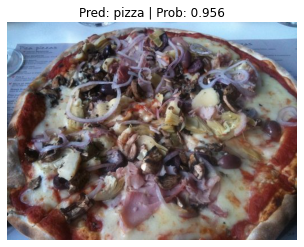

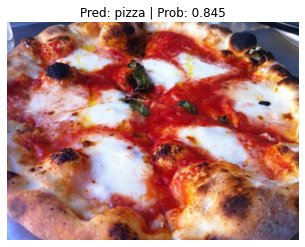

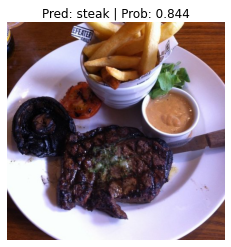

In [110]:
# Import function to make predictions on images and plot them 
# See the function previously created in section: https://www.learnpytorch.io/06_pytorch_transfer_learning/#6-make-predictions-on-images-from-the-test-set
from going_modular.going_modular.predictions import pred_and_plot_image

# Get a random list of 3 images from 20% test set
import random
num_images_to_plot = 3
test_image_path_list = list(Path(data_20_percent_path / "test").glob("*/*.jpg")) # get all test image paths from 20% dataset
test_image_path_sample = random.sample(population=test_image_path_list,
                                       k=num_images_to_plot) # randomly select k number of images

# Iterate through random test image paths, make predictions on them and plot them
for image_path in test_image_path_sample:
    pred_and_plot_image(model=best_model,
                        image_path=image_path,
                        class_names=class_names,
                        image_size=(224, 224))

Nice!

Running the cell above a few times we can see our model performs quite well and often has higher prediction probabilities than previous models we've built.

This suggests the model is more confident in the decisions it's making. 

### TK - 9.1 Predict on a custom image with the best model

Making predictions on the test dataset is cool but the real magic of machine learning is making predictions on custom images of your own.

So let's import the trusty [pizza dad image](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/images/04-pizza-dad.jpeg) (a photo of my dad in front of a pizza) we've been using for the past couple of sections and see how our model performs on it.

data/04-pizza-dad.jpeg already exists, skipping download.


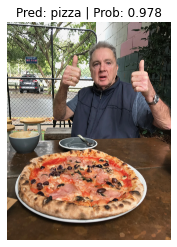

In [111]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = Path("data/04-pizza-dad.jpeg")

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)

Woah!

Two thumbs again!

Our best model predicts "pizza" correctly and this time with an even higher prediction probability (0.978 vs 0.517) than the first feature extraction model we trained and used in [06. PyTorch Transfer Learning section 6.1](https://www.learnpytorch.io/06_pytorch_transfer_learning/#61-making-predictions-on-a-custom-image).

This again suggests our current best model (EffNetB2 feature extractor trained on 20% of the pizza, steak, sushi training data and for 10 epochs) has learned patterns to make it more confident of its decision to predict pizza.

I wonder what could improve our model's performance even further? 

I'll leave that as a challenge for you to investigate.

## Exercises
UPTOHERE: Going through and setting up the new exercises (might have to change these + the material to suit the v0.13 API...)

* Pick a larger model from [`torchvision.models`](https://pytorch.org/vision/main/models.html) to add to the list of experiments. You'll want a How does it perform compared to our existing models?
* Introduce data augmentation to the list of experiments using the 20% pizza, steak, sushi training and test datasets, does this change anything?
    * For example, you could have one training DataLoader that uses data augmentation (e.g. `train_dataloader_20_percent_aug` and `train_dataloader_20_percent_no_aug`) and then compare the results of two of the same model types training on these two DataLoaders.
    * Note: You may need to alter the `create_dataloaders()` function to be able to take a transform for the training data and the testing data (because you don't need to perform data augmentation on the test data).
    * See [04. PyTorch Custom Datasets section 6](https://www.learnpytorch.io/04_pytorch_custom_datasets/#6-other-forms-of-transforms-data-augmentation) for examples of using data augmentation.
* Scale up the dataset (e.g. could use *all* of Food101 + design 2 experiments, perhaps a large and a small model, track experiments)
* Could use the following for data augmentation:

```python
# Note: Data augmentation transform like this should only be performed on training data
train_transform_data_aug = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.TrivialAugmentWide(),
    transforms.ToTensor(),
    normalize
])

# And to view images...
def view_dataloader_images(dataloader, n=10):
    if n > 10:
        print(f"Having n higher than 10 will create messy plots, lowering to 10.")
        n = 10
    imgs, labels = next(iter(train_dataloader_aug))
    plt.figure(figsize=(16, 8))
    for i in range(n):
        # Min max scale the image for display purposes
        targ_image = imgs[i]
        sample_min, sample_max = targ_image.min(), targ_image.max()
        sample_scaled = (targ_image - sample_min)/(sample_max - sample_min)

        # Plot images with appropriate axes information
        plt.subplot(1, 10, i+1)
        plt.imshow(sample_scaled.permute(1, 2, 0)) # resize for Matplotlib requirements
        plt.title(class_names[labels[i]])
        plt.axis(False)

# Have to update `create_dataloaders()` to handle different augmentations
import os
from torch.utils.data import DataLoader
from torchvision import datasets

NUM_WORKERS = os.cpu_count() # use maximum number of CPUs for workers to load data 

# Note: this is an update version of data_setup.create_dataloaders to handle
# differnt train and test transforms.
def create_dataloaders(
    train_dir, 
    test_dir, 
    train_transform, # add parameter for train transform (transforms on train dataset)
    test_transform,  # add parameter for test transform (transforms on test dataset)
    batch_size=32, num_workers=NUM_WORKERS
):
    # Use ImageFolder to create dataset(s)
    train_data = datasets.ImageFolder(train_dir, transform=train_transform)
    test_data = datasets.ImageFolder(test_dir, transform=test_transform)

    # Get class names
    class_names = train_data.classes

    # Turn images into data loaders
    train_dataloader = DataLoader(
        train_data,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
    )
    test_dataloader = DataLoader(
        test_data,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
    )

    return train_dataloader, test_dataloader, class_names
```

## Extra-curriculum

* You can see a tensorboard guide to using tensorboard logs with dataframes here - https://www.tensorflow.org/tensorboard/dataframe_api 
* Check out the PyTorch YouTube tutorial for TensorBoard -- https://pytorch.org/tutorials/beginner/introyt/tensorboardyt_tutorial.html 
* See here for more on the profiler: https://pytorch.org/blog/introducing-pytorch-profiler-the-new-and-improved-performance-tool/
* See here on setting up TensorBoard in VSCode: https://code.visualstudio.com/docs/datascience/pytorch-support
* See more on ML experiment tracking - https://madewithml.com/courses/mlops/experiment-tracking/ 
* Does changing the data input size to EfficientNetB4 change its results? E.g. input image size of (380, 380) instead of (224, 224)?